In [77]:
import os
from tqdm import tqdm_notebook
import json
import numpy as np
import scipy.io.wavfile
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.transform import resize
import scipy.misc
import PIL
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

In [3]:
wav_dir = '../../AudioMNIST/data' 
meta_fpath = f'{wav_dir}/audioMNIST_meta.txt'

In [4]:
with open(meta_fpath) as json_f:
    meta = json.load(json_f)

In [8]:
male_idxs, female_idxs = [], []
for idx, info in meta.items():
    if info['gender'].lower() == 'male':
        male_idxs.append(idx)
    elif info['gender'].lower() == 'female':
        female_idxs.append(idx)

In [9]:
def get_wav_fpaths_from_participant_indices(idxs):
    wav_fpaths = []
    for idx in idxs:
        for fname in os.listdir(f'{wav_dir}/{idx}'):
            wav_fpaths.append(f'{wav_dir}/{idx}/{fname}')
    return wav_fpaths

In [22]:
male_wav_fpaths = get_wav_fpaths_from_participant_indices(male_idxs)
female_wav_fpaths = get_wav_fpaths_from_participant_indices(female_idxs)

In [81]:
ipd.Audio(male_wav_fpaths[666])

In [80]:
ipd.Audio(female_wav_fpaths[999])

In [29]:
def pad_signal(signal, target_len):
    
    num_zeros_needed = target_len - len(signal)
    
    if num_zeros_needed > 0:

        num_zeros_front = np.random.randint(num_zeros_needed)
        num_zeros_back = num_zeros_needed - num_zeros_front
        return np.pad(signal, (num_zeros_front, num_zeros_back), mode='constant')

    else:
        return signal

In [13]:
PRE_EMPHASIS_COEFF = 0.97

In [14]:
def pre_emphasis(signal):
    first_amp = signal[0]
    all_amps_without_first = signal[1:]
    all_amps_without_last = signal[:-1]
    emphasized_signal = np.append(first_amp, all_amps_without_first - PRE_EMPHASIS_COEFF * all_amps_without_last)
    return emphasized_signal

In [15]:
def pipeline(signal):
    
    emphasized_signal = pre_emphasis(signal)
    
    # the following code applies dft, mel filter banks, logging, dct and normalization all at once
    # truly convenient
    
    lifted_mfcc = librosa.feature.mfcc(
        y=emphasized_signal.astype(float), 
        sr=sample_rate, 
        n_mfcc=12, 
        dct_type=2, 
        norm='ortho', 
        lifter=22,
        n_fft = int(sample_rate * 0.025),
        hop_length= int(sample_rate * 0.01),
        power=2,
        center=False,
        window='hanning',
        n_mels=40
    )

    return lifted_mfcc

In [71]:
os.makedirs('/home/yangz2/.ml_datasets')

FileExistsError: [Errno 17] File exists: '/home/yangz2/.ml_datasets'

In [19]:
sample_rate = librosa.core.get_samplerate(wav_fpaths[0])

In [75]:
sample_rate

48000

In [20]:
def get_max_duration(filenames):
    """
    Return the maximum duration in seconds for a group of wav files.
    This is much faster than loading all the wav files into numpy arrays and using the shape attribute.
    """
    max_duration = 0
    for fn in tqdm_notebook(filenames):
        duration = librosa.core.audio.get_duration(filename=fn)
        if duration > max_duration:
            max_duration = duration
    return max_duration

In [21]:
max_duration = get_max_duration(wav_fpaths)

In [76]:
max_duration

0.9999583333333333

In [23]:
max_samples = int(max_duration * sample_rate)
print(max_samples)

47998


## Testing

In [61]:
np.random.seed(42)
_, signal = scipy.io.wavfile.read(male_wav_fpaths[0])
signal = pad_signal(signal, target_len=max_samples)

255 0 33.33237005739796


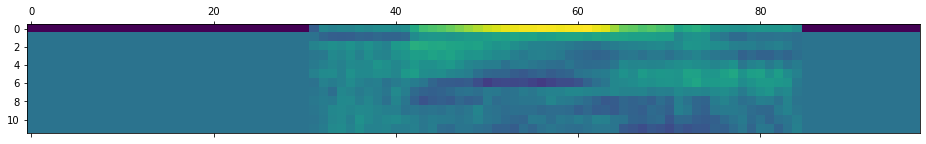

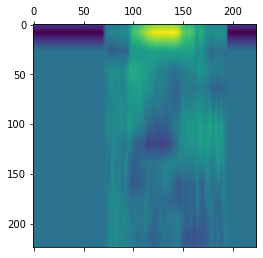

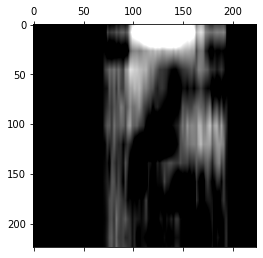

In [64]:
mfc = pipeline(signal)
mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
mfc_img = scipy.misc.toimage(mfc_3d, cmin=0, cmax=255)
print(np.array(mfc_img).max(), np.array(mfc_img).min(), np.array(mfc_img).mean())
plt.matshow(mfc)
plt.matshow(mfc_3d[:,:,2])
plt.matshow(mfc_img)
plt.show()

## Outputing

In [72]:
dataset_dir = '/home/yangz2/.ml_datasets/gender_audio_classification'
os.makedirs(dataset_dir)

In [73]:
for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    _, signal = scipy.io.wavfile.read(fp)  # faster than librosa
    signal = pad_signal(signal, target_len=max_samples)
    mfc = pipeline(signal)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
    scipy.misc.toimage(mfc_3d, cmin=0, cmax=255).save(f'{dataset_dir}/male_{i}.jpg')

In [74]:
for i, fp in tqdm_notebook(enumerate(female_wav_fpaths), total=len(female_wav_fpaths)):
    _, signal = scipy.io.wavfile.read(fp)  # faster than librosa
    signal = pad_signal(signal, target_len=max_samples)
    mfc = pipeline(signal)
    mfc_3d = resize(np.rollaxis(np.array([mfc] * 3), 0, 3), (224, 224, 3))
    scipy.misc.toimage(mfc_3d, cmin=0, cmax=255).save(f'{dataset_dir}/female_{i}.jpg')